statistical summary of data

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib  # For saving the model


In [2]:
df_train = pd.read_csv('/kaggle/input/imlcomp1/train_set.csv')

df_test = pd.read_csv('/kaggle/input/imlcomp1/test_set.csv')

In [3]:
# Step 3: Preview the data to understand the structure

df_train.head()

,RecordId,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X70,X71,X72,X73,X74,X75,X76,X77,X78,Y
0,1,87.000000,34.118411,0,2,0,165.100000,1,829,2,...,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,82.372284,31.573280,0,0,1,162.983897,1,724,0,...,0.033431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3,50.000000,27.771653,0,0,1,165.100000,1,895,2,...,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4,66.236109,26.515922,0,0,1,167.009549,1,637,0,...,0.039363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5,81.303299,20.843691,0,0,1,158.165419,0,564,0,...,0.069242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
df_test.head()

,RecordId,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78
0,300001,79.000000,17.122318,0,0,1,170.200000,1,700,0,...,0.070000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,300002,38.000000,43.693579,0,0,1,165.100000,1,814,0,...,0.050000,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,300003,36.064225,23.998944,0,0,1,167.086735,1,662,0,...,0.006948,0.006948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,300004,61.846764,31.693449,0,3,1,182.355708,2,862,0,...,0.062613,0.033153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,300005,71.591991,20.086147,1,0,1,166.704917,2,335,0,...,0.014854,0.004854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
numeric_mean_train = df_train.loc[:, df_train.columns != 'Y'].select_dtypes(include=np.number).mean()


In [6]:
df_train.fillna(numeric_mean_train, inplace=True)

In [7]:
numeric_mean_test = df_test.select_dtypes(include=np.number).mean()

df_test.fillna(numeric_mean_test, inplace=True)

In [8]:
X_original = df_train.iloc[:, :-1]  # All columns except the last one

y_original = df_train.iloc[:, -1]   # The last column is the target

In [9]:
X_original

,RecordId,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78
0,1,87.000000,34.118411,0,2,0,165.100000,1,829,2,...,0.110000,0.040000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,2,82.372284,31.573280,0,0,1,162.983897,1,724,0,...,0.100292,0.033431,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,3,50.000000,27.771653,0,0,1,165.100000,1,895,2,...,0.020000,0.010000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,4,66.236109,26.515922,0,0,1,167.009549,1,637,0,...,0.108249,0.039363,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,5,81.303299,20.843691,0,0,1,158.165419,0,564,0,...,0.164645,0.069242,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246117,246118,65.149110,33.357948,0,0,1,156.317941,1,711,0,...,0.088610,0.027152,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
246118,246119,48.000000,46.736176,0,0,1,157.000000,1,594,2,...,-1.000000,0.560000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
246119,246120,57.472080,41.854115,1,0,0,189.868698,2,455,0,...,0.032961,0.020601,0.0,0.0,0.587987,0.0,0.412013,0.0,0.0,0.412013
246120,246121,66.000000,23.738662,1,0,1,168.000000,2,609,0,...,0.020000,-1.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000


In [10]:
y_original

0         0
1         0
2         0
3         0
4         0
         ..
246117    0
246118    1
246119    0
246120    0
246121    0
Name: Y, Length: 246122, dtype: int64

In [11]:
# Count the number of positive and negative instances
positive_count = (df_train['Y'] == 1).sum()
negative_count = (df_train['Y'] == 0).sum()

# Separate features and target
X = df_train.drop('Y', axis=1)  # Features (if any)
y = df_train['Y']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

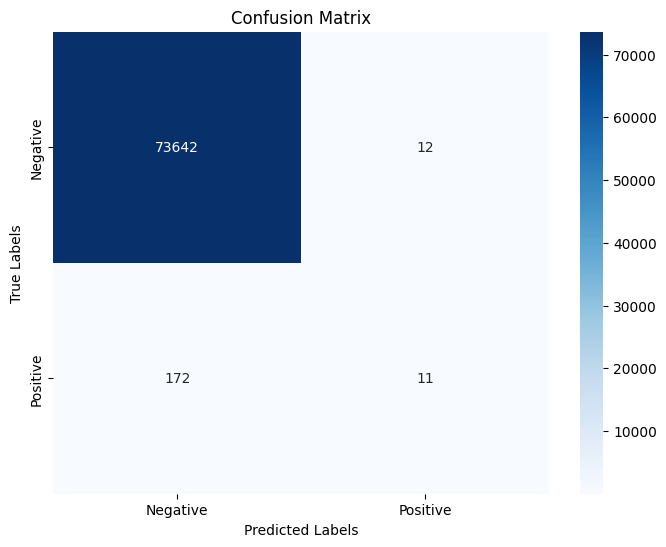

Accuracy: 99.75%
AUC: 0.68


In [13]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score


#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_original, y_original, 
    test_size=0.3, 
    random_state=42, 
    shuffle=True  # This is the default behavior
)
# X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

#Initialize the Decision Tree Classifier with specific parameters
clf = DecisionTreeClassifier(
    criterion='gini',          # Measure quality of a split (can use 'entropy' for information gain)
    splitter='best',           # Choose the best split (or 'random' for random splits)
    max_depth=3,               # Limit the depth of the tree to 3 levels
    min_samples_split=4,       # Require at least 4 samples to make a split
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    random_state=42            # For reproducibility
)

#Train the classifier
clf.fit(X_train, y_train)

#Make predictions on the test set
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate ROC curve and AUC
y_prob = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

In [14]:
clf = DecisionTreeClassifier(
    criterion='gini',          # Measure quality of a split (can use 'entropy' for information gain)
    splitter='best',           # Choose the best split (or 'random' for random splits)
    max_depth=3,               # Limit the depth of the tree to 3 levels
    min_samples_split=4,       # Require at least 4 samples to make a split
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    random_state=42            # For reproducibility
)

#Train the classifier
clf.fit(X_original, y_original)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=4,
                       random_state=42)

In [15]:
X_original

,RecordId,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78
0,1,87.000000,34.118411,0,2,0,165.100000,1,829,2,...,0.110000,0.040000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,2,82.372284,31.573280,0,0,1,162.983897,1,724,0,...,0.100292,0.033431,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,3,50.000000,27.771653,0,0,1,165.100000,1,895,2,...,0.020000,0.010000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,4,66.236109,26.515922,0,0,1,167.009549,1,637,0,...,0.108249,0.039363,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,5,81.303299,20.843691,0,0,1,158.165419,0,564,0,...,0.164645,0.069242,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246117,246118,65.149110,33.357948,0,0,1,156.317941,1,711,0,...,0.088610,0.027152,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
246118,246119,48.000000,46.736176,0,0,1,157.000000,1,594,2,...,-1.000000,0.560000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
246119,246120,57.472080,41.854115,1,0,0,189.868698,2,455,0,...,0.032961,0.020601,0.0,0.0,0.587987,0.0,0.412013,0.0,0.0,0.412013
246120,246121,66.000000,23.738662,1,0,1,168.000000,2,609,0,...,0.020000,-1.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000


In [16]:
df_test

,RecordId,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78
0,300001,79.000000,17.122318,0,0,1,170.200000,1,700,0,...,0.070000,0.030000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
1,300002,38.000000,43.693579,0,0,1,165.100000,1,814,0,...,0.050000,0.040000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
2,300003,36.064225,23.998944,0,0,1,167.086735,1,662,0,...,0.006948,0.006948,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
3,300004,61.846764,31.693449,0,3,1,182.355708,2,862,0,...,0.062613,0.033153,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
4,300005,71.591991,20.086147,1,0,1,166.704917,2,335,0,...,0.014854,0.004854,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105477,405478,35.781006,25.569364,0,0,1,158.542014,1,238,0,...,0.013678,0.002452,0.0,0.0,0.000000,0.12259,0.0,0.0,0.0,0.0
105478,405479,73.000000,30.849795,0,0,0,182.900000,1,114,0,...,0.830000,0.730000,0.0,0.0,1.000000,0.00000,0.0,0.0,0.0,0.0
105479,405480,61.872510,31.609595,0,4,1,155.783272,1,536,0,...,0.172681,0.079609,0.0,0.0,0.826809,0.00000,0.0,0.0,0.0,0.0
105480,405481,58.722824,34.631254,1,0,1,174.474165,2,517,0,...,0.000904,0.000602,0.0,0.0,0.969882,0.00000,0.0,0.0,0.0,0.0


In [17]:
# Make predictions on the test set
y_test_pred = clf.predict(df_test)

# Save the test predictions (if needed)
df_test['Y'] = y_test_pred
df_test[['RecordId', 'Y']].to_csv('test_predictions.csv', index=False)

print("Predictions made on the test set and saved to 'test_predictions.csv'.")

Predictions made on the test set and saved to 'test_predictions.csv'.
